In [1]:
# ===============================
# FRAUD DETECTION PROJECT - STAGE 1
# ===============================

# Step 1: Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Models
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# Explainability
import shap

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


C:\Users\Charan Varma\anaconda3\envs\fraud_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


In [2]:
pip install xgboost

In [3]:
!pip install xgboost

In [4]:
# ===============================
# STAGE 2: Load and explore dataset
# ===============================

# Load dataset
data = pd.read_csv('data/creditcard.csv')

# Display basic info
print("Dataset shape:", data.shape)
print("\nColumns:\n", data.columns)

# Preview first few rows
data.head()


Dataset shape: (284807, 31)

Columns:
 Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# ===============================
# STAGE 3: Data Preprocessing
# ===============================

# Feature scaling for 'Time' and 'Amount'
scaler = StandardScaler()
data['Scaled_Amount'] = scaler.fit_transform(data[['Amount']])
data['Scaled_Time'] = scaler.fit_transform(data[['Time']])

# Drop old columns
data = data.drop(['Time', 'Amount'], axis=1)

# Separate features and target
X = data.drop('Class', axis=1)
y = data['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("✅ Data preprocessing complete!")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

✅ Data preprocessing complete!
Training samples: 227845
Testing samples: 56962


Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


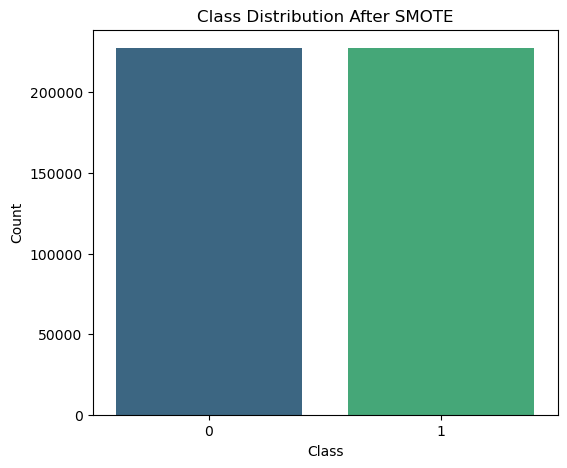

In [6]:
# ===============================
# STAGE 4: Balance dataset using SMOTE
# ===============================

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_bal.value_counts())

plt.figure(figsize=(6,5))
sns.barplot(x=y_train_bal.value_counts().index, y=y_train_bal.value_counts().values, palette='viridis')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

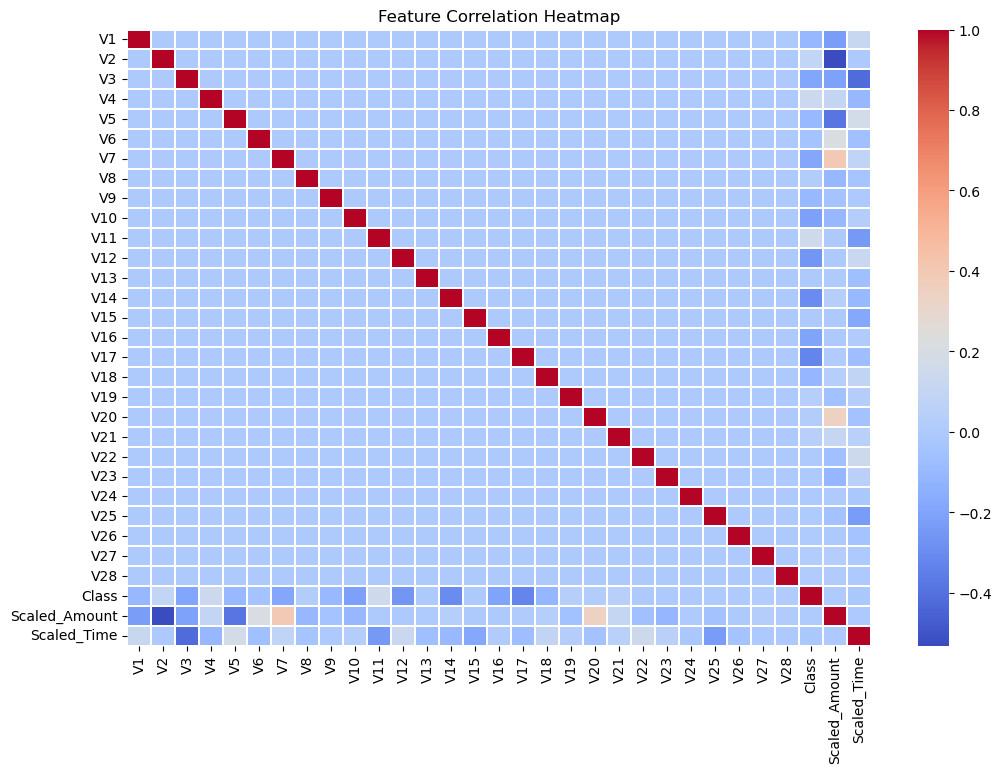

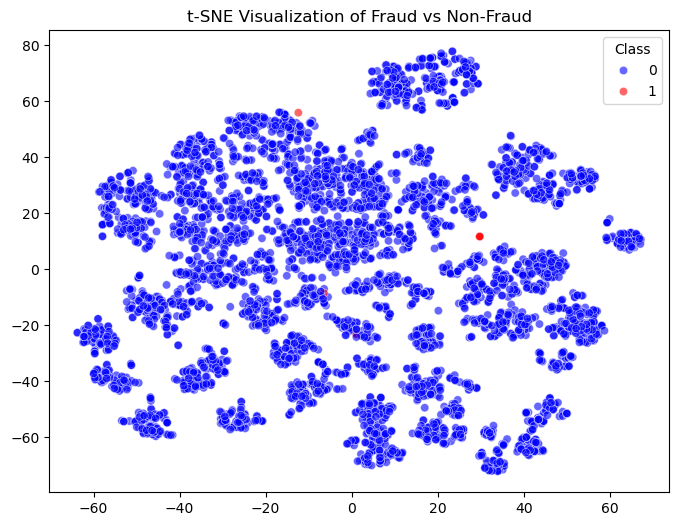

In [7]:
# ===============================
# STAGE 5: Exploratory Data Analysis
# ===============================

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), cmap='coolwarm', linewidths=0.2)
plt.title('Feature Correlation Heatmap')
plt.show()

# t-SNE visualization (optional but high-impact)
from sklearn.manifold import TSNE

# Use a smaller subset for visualization (to save time)
subset = data.sample(5000, random_state=42)
X_tsne = subset.drop('Class', axis=1)
y_tsne = subset['Class']

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_tsne)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_tsne, palette=['blue', 'red'], alpha=0.6)
plt.title('t-SNE Visualization of Fraud vs Non-Fraud')
plt.show()

Isolation Forest model trained!

Classification Report (Isolation Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.33      0.32        98

    accuracy                           1.00     56962
   macro avg       0.65      0.66      0.66     56962
weighted avg       1.00      1.00      1.00     56962



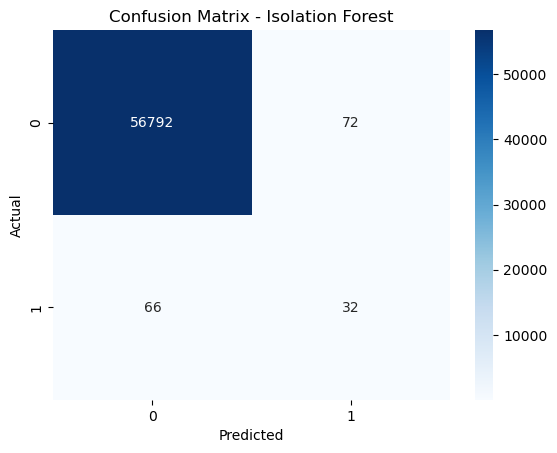

In [8]:
# ===============================
# STAGE 6.1 - Isolation Forest
# ===============================

iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.0017,  # % of fraud cases in data
    random_state=42
)

iso_forest.fit(X_train)

# Predict anomalies (-1 = fraud, 1 = normal)
y_pred_iso = iso_forest.predict(X_test)

# Convert -1 to 1 (fraud), and 1 to 0 (non-fraud)
y_pred_iso = [1 if i == -1 else 0 for i in y_pred_iso]

print("Isolation Forest model trained!")

# Evaluate
print("\nClassification Report (Isolation Forest):")
print(classification_report(y_test, y_pred_iso))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_iso)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Local Outlier Factor model evaluated!

Classification Report (LOF):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.02      0.02      0.02        98

    accuracy                           1.00     56962
   macro avg       0.51      0.51      0.51     56962
weighted avg       1.00      1.00      1.00     56962



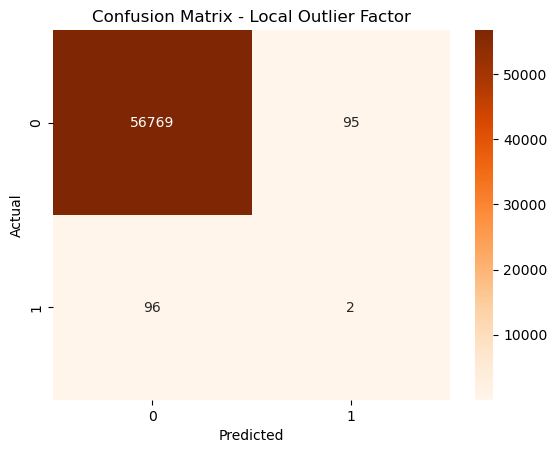

In [9]:
# ===============================
# STAGE 6.2 - Local Outlier Factor
# ===============================

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017)
y_pred_lof = lof.fit_predict(X_test)
y_pred_lof = [1 if i == -1 else 0 for i in y_pred_lof]

print("Local Outlier Factor model evaluated!")

# Evaluate
print("\nClassification Report (LOF):")
print(classification_report(y_test, y_pred_lof))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lof)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Local Outlier Factor')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


XGBoost model trained!

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.63      0.87      0.73        98

    accuracy                           1.00     56962
   macro avg       0.82      0.93      0.87     56962
weighted avg       1.00      1.00      1.00     56962



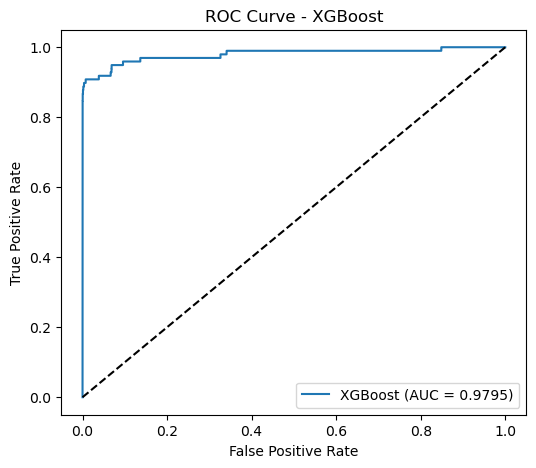

In [10]:
# ===============================
# STAGE 6.3 - XGBoost Classifier
# ===============================

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

print("XGBoost model trained!")

# Evaluate
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
roc_auc = roc_auc_score(y_test, y_proba_xgb)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.show()

In [11]:
# ===============================
# STAGE 6.4 - Model Comparison
# ===============================

def evaluate_model(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return {
        'Model': model_name,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4),
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    }

results = []
results.append(evaluate_model(y_test, y_pred_iso, 'Isolation Forest'))
results.append(evaluate_model(y_test, y_pred_lof, 'Local Outlier Factor'))
results.append(evaluate_model(y_test, y_pred_xgb, 'XGBoost'))

df_results = pd.DataFrame(results)
df_results.sort_values(by='F1-Score', ascending=False, inplace=True)

print("Model Performance Comparison:")
display(df_results)


Model Performance Comparison:


,Model,Precision,Recall,F1-Score,TP,FP,FN,TN
2,XGBoost,0.6343,0.8673,0.7328,85,49,13,56815
0,Isolation Forest,0.3077,0.3265,0.3168,32,72,66,56792
1,Local Outlier Factor,0.0206,0.0204,0.0205,2,95,96,56769


In [12]:
# ===============================
# STAGE 6.5 - Save Best Model
# ===============================
import joblib

joblib.dump(xgb, '../models/xgboost_fraud_model.pkl')
print("XGBoost model saved successfully in folder!")


XGBoost model saved successfully in folder!


In [14]:
import joblib
xgb = joblib.load('../models/xgboost_fraud_model.pkl')
print("XGBoost model loaded successfully!")


XGBoost model loaded successfully!


In [15]:
# ===============================
# STAGE 7.1 - Initialize SHAP
# ===============================

# This assumes 'xgb' (your trained model) and 'X_test' are already loaded from previous cells
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

print("SHAP explainer created and values calculated!")

SHAP explainer created and values calculated!


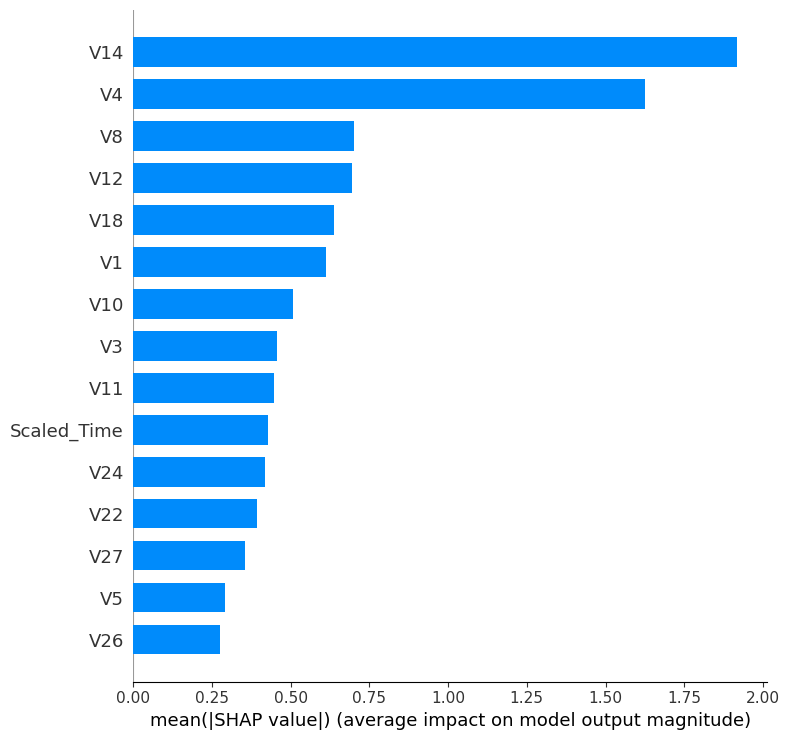

In [16]:
# ===============================
# STAGE 7.2 - Global Feature Importance
# ===============================

plt.title("Top Features Impacting Fraud Predictions")
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)


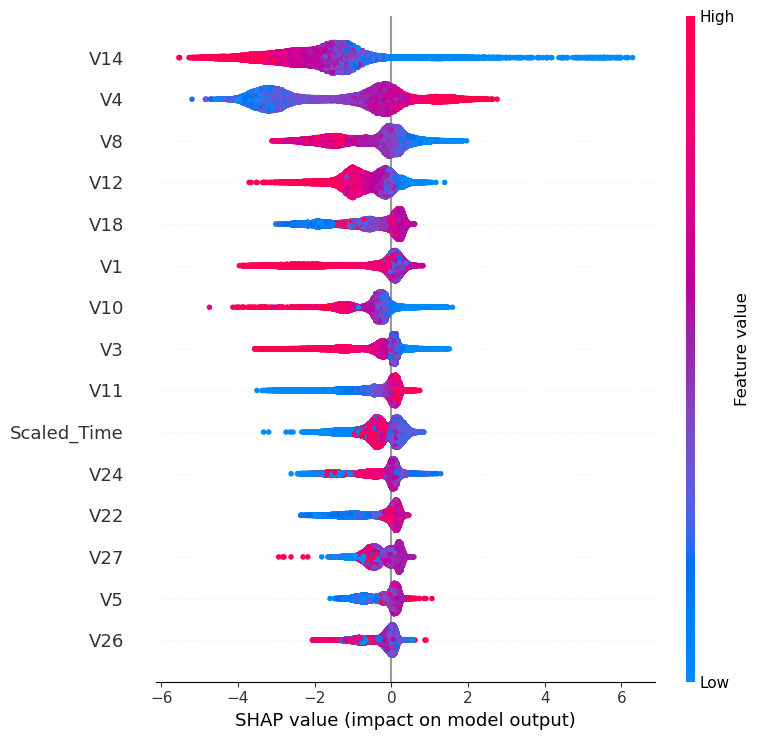

In [17]:
# ===============================
# STAGE 7.3 - Detailed SHAP Summary Plot
# ===============================

shap.summary_plot(shap_values, X_test, max_display=15)


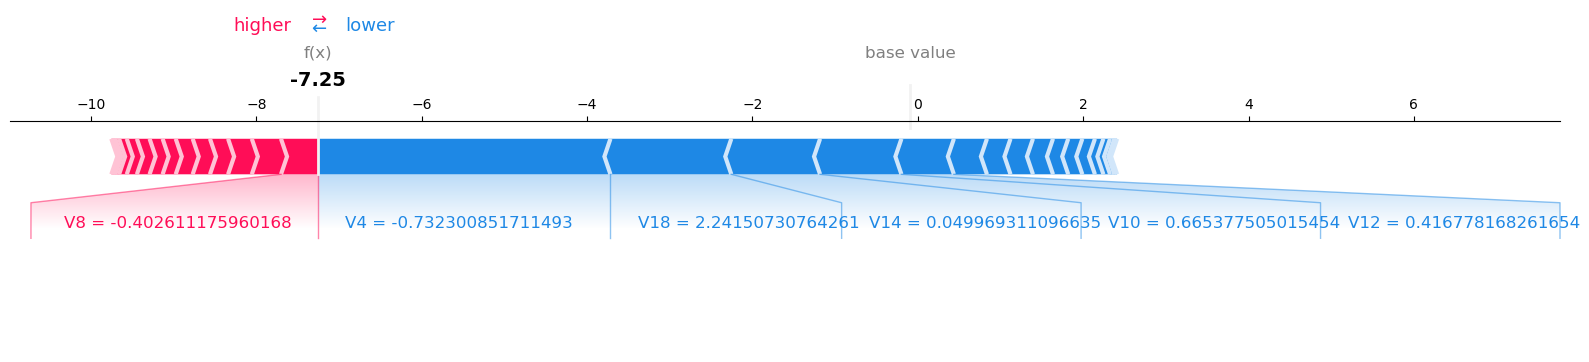

In [18]:
# ===============================
# STAGE 7.4 - Single Transaction Explanation
# ===============================

# Choose a random transaction
sample_idx = 100  # you can change this index
sample = X_test.iloc[[sample_idx]]

# Explain the prediction for this sample
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx, :],
    sample,
    matplotlib=True
)


Saved SHAP summary plot to reports folder!


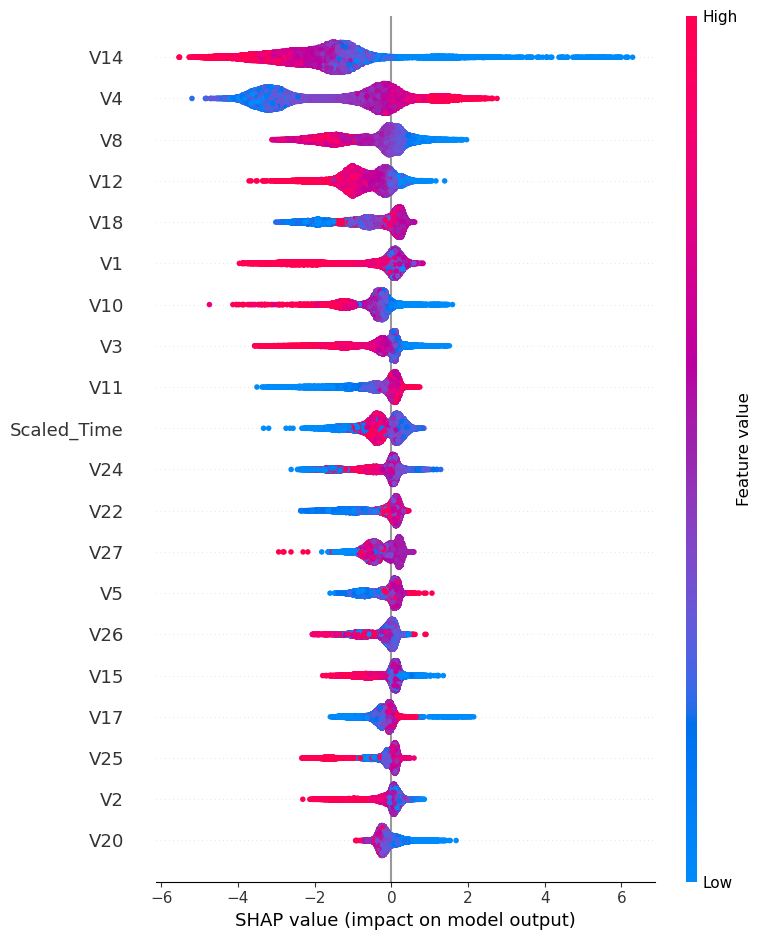

In [19]:
# ===============================
# STAGE 7.5 - Save Plots for Report
# ===============================

plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("../reports/shap_summary_plot.png", bbox_inches='tight', dpi=300)
print("Saved SHAP summary plot to reports folder!")
